In [1]:
import datgan
print(datgan.__version__)

from datgan import DATGAN, advise

import numpy as np
import pandas as pd
import networkx as nx
import tensorflow as tf

# Run the model eagerly
#tf.config.run_functions_eagerly(True)

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

2.1.2


# Load the original data

In [2]:
df = pd.read_csv('./data/CMAP.csv', index_col=False)

In [3]:
df.head()

,choice,travel_dow,trip_purpose,distance,hh_vehicles,hh_size,hh_bikes,hh_descr,hh_income,gender,age,license,education_level,work_status,departure_time
0,drive,7,HOME_OTHER,3.93477,2,3,3,detached,6,0,30,1,4,PTE,20.166667
1,drive,2,SHOPPING,0.31557,3,3,3,detached,7,0,54,1,5,FTE,17.500000
2,drive,2,SHOPPING,0.28349,1,1,0,detached,3,0,80,1,3,PTE,9.333333
3,drive,2,OTHER,0.69417,2,2,0,detached,5,1,42,1,5,FTE,13.783333
4,passenger,1,SHOPPING,4.30666,2,2,1,detached,4,0,32,0,3,Unemployed,11.566667


# Provide information on the data

We need to provide the data type for each columns and give a bit more information about continuous columns.

In our case, the `distance` is an exponential distriubtion => we transform it using a logarithm in order to make it easier for the generator to learn the distribution.

In [4]:
# First, define the specificities of continuous variables
data_info = {
    'distance': {
        'type': 'continuous',
        'bounds': [0.0, np.infty],
        'discrete': False,
        'apply_func': (lambda x: np.log(x+1)),
    },
    'age': {
        'type': 'continuous',
        'bounds': [0, 100],
        'enforce_bounds': True,
        'discrete': True
    },
    'departure_time': {
        'type': 'continuous',
        'bounds': [0, 23.999],
        'discrete': False
    }
}

# Add the other variables as categorical
for c in df.columns:
    if c not in data_info.keys():
        data_info[c] = {'type': 'categorical'}

# DAG

We need to define the DAG using the library `networkx`. 

```
We highly recommend creating this DAG using a "drawing" tool in order to better visualize the DAG. It will be easier to create it this way.
```

In [5]:
graph = nx.DiGraph()
graph.add_edges_from([
    ("age", "license"),
    ("age", "education_level"),
    ("gender", "work_status"),
    ("education_level", "work_status"),
    ("education_level", "hh_income"),
    ("work_status", "hh_income"),
    ("hh_income", "hh_descr"),
    ("hh_income", "hh_size"),
    ("hh_size", "hh_vehicles"),
    ("hh_size", "hh_bikes"),
    ("work_status", "trip_purpose"),
    ("trip_purpose", "departure_time"),
    ("trip_purpose", "distance"),
    ("travel_dow", "choice"),
    ("distance", "choice"),
    ("departure_time", "choice"),
    ("hh_vehicles", "choice"),
    ("hh_bikes", "choice"),
    ("license", "choice"),
    ("education_level", "hh_size"),
    ("work_status", "hh_descr"),
    ("work_status", "hh_size"),
    ("hh_income", "hh_bikes"),
    ("hh_income", "hh_vehicles"),
    ("trip_purpose", "choice")
])

There is a function `advise` that checks Pearson and Spearman correlations between each variables and suggests which edges could be added to the DAG. 

Preparing advice...
You might want to add the following edges in your DAG (direction not given here):
  - license <-> education_level
  - license <-> work_status
  - hh_vehicles <-> hh_descr
  - hh_bikes <-> age
  - hh_size <-> age


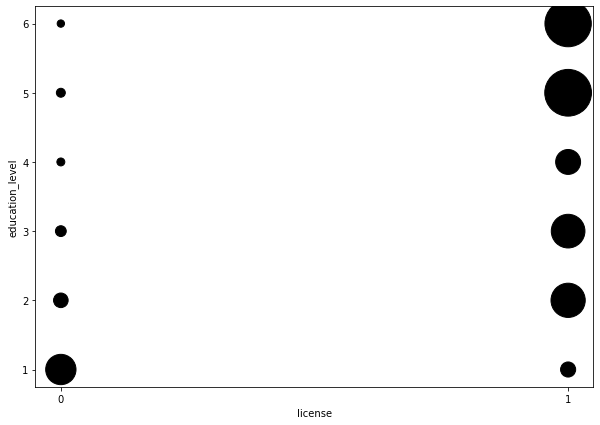

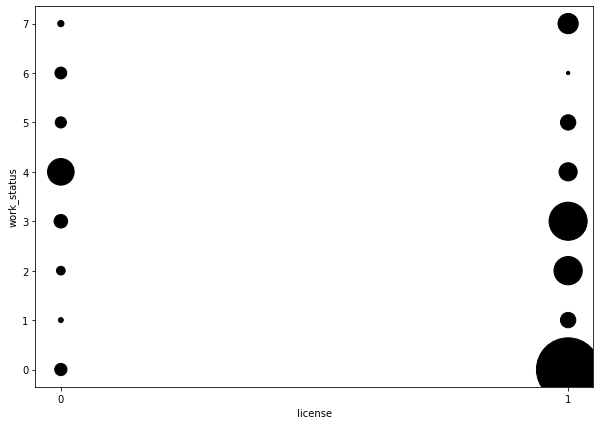

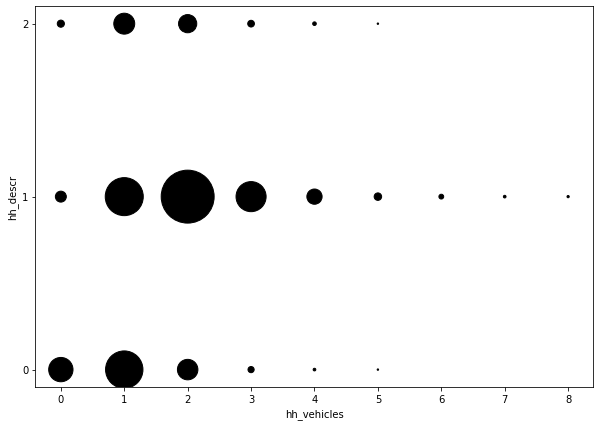

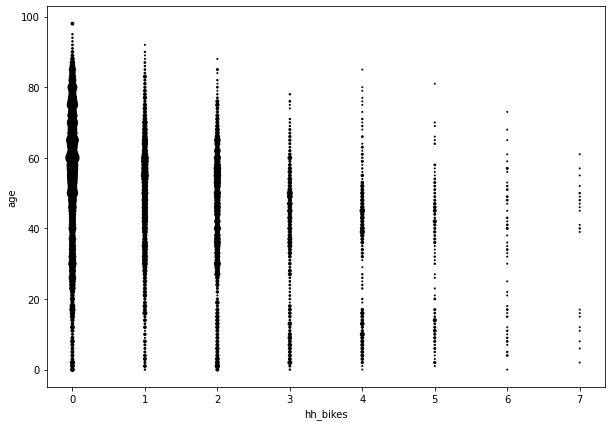

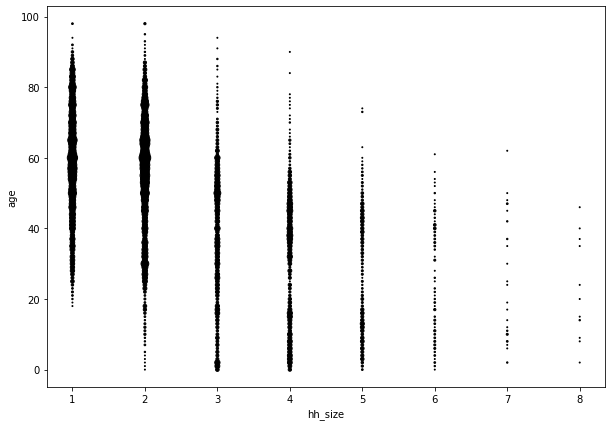

In [6]:
advise(df, graph, plot_graphs=True)

# Train the DATGAN

In [ ]:
# Choosing the right batch size allows to not waste data while training the models
batch_size = 1116

In [7]:
output_folder = './output/'

In [8]:
datgan = DATGAN(output=output_folder, batch_size=batch_size, num_epochs=1000)

It is possible to preprocess the data and save it somewhere. Since it takes a bit of time to do it, it helps to test multiple models faster. 

In [9]:
datgan.preprocess(df, data_info, preprocessed_data_path='./encoded_data')

Preprocessing the data!
Encoding categorical variable "choice"...
Encoding categorical variable "travel_dow"...
Encoding categorical variable "trip_purpose"...
Encoding continuous variable "distance"...
Encoding categorical variable "hh_vehicles"...
Encoding categorical variable "hh_size"...
Encoding categorical variable "hh_bikes"...
Encoding categorical variable "hh_descr"...
Encoding categorical variable "hh_income"...
Encoding categorical variable "gender"...
Encoding continuous variable "age"...
Encoding categorical variable "license"...
Encoding categorical variable "education_level"...
Encoding categorical variable "work_status"...
Encoding continuous variable "departure_time"...
Preprocessed data have been saved in './encoded_data'


If the data has been preprocessed, you need to provide the path where it was saved. The model will then load the preprocessed data and work with it. If no preprocessed data are found in the specified folder, the model will still preprocess them before training the networks.

In [10]:
datgan.fit(df, data_info, graph, preprocessed_data_path='./encoded_data')

Preprocessed data have been loaded!
Start training DATGAN with the WGAN loss (21/03/2022 15:08:31).


Training DATGAN: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [23:35<00:00,  1.42s/it]

DATGAN has finished training (21/03/2022 15:32:06) - Training time: 23 minutes and 35 seconds


Sample the synthetic data

In [11]:
samples = datgan.sample(len(df))

Sampling from DATGAN: 100%|██████████████████████████████████████████████████████| 8929/8929 [00:02<00:00, 3793.09it/s]


Save the new dataset

In [12]:
samples.to_csv('./data/DATGAN.csv', index=False)

## Sample with conditionals

You can use simple conditionals while sampling data after training the DATGAN. You need to provide information in a dictionary:
- **categorical variables:** Provide a string or a list of string elemets corresponding the categories you want to get
- **continuous variables:** Provide a lambda function that returns a boolean value

In [13]:
cond_dict = {'choice': ['cycle', 'passenger'], 'age': lambda x: x<30}

In [14]:
samples = datgan.sample(len(df), cond_dict=cond_dict)

Sampling from DATGAN: 100%|███████████████████████████████████████████████████████| 8929/8929 [00:34<00:00, 255.18it/s]


In [15]:
samples.to_csv('./data/DATGAN_cond.csv', index=False)

# Train DATGAN with conditional inputs

The DATGAN has been upgraded such that you can train it using some of the columns in the dataset as *conditional inputs*. This means that the specified variables will not be generated by the DATGAN. This allows to input data coming from a different dataset in the DATGAN as inputs for the sampling process. The model will then generate the remaining variables.

In order to use the conditional inputs, you *do not* need to change the DAG or the encoded data. You just need to add a list of conditional inputs.

In [6]:
output_folder = './output_cond/'

In [10]:
datgan_cond = DATGAN(output=output_folder, 
                     batch_size=batch_size,
                     conditional_inputs = ['age', 'gender', 'trip_purpose'],
                     num_epochs=1000)

In [11]:
datgan_cond.fit(df, data_info, graph, preprocessed_data_path='./encoded_data')

Preprocessed data have been loaded!
Start training DATGAN with the WGAN loss (17/03/2022 15:38:55).
Restored models from epoch 1000.


Training DATGAN: 0it [00:00, ?it/s]

DATGAN has finished training (17/03/2022 15:38:55) - Training time: 00 second


In order to sample synthetic data, we need to provide a dataset containing the variables the variables given as conditional inputs. If we want to generate the same dataset as the original one, you can simply pass the corresponding columns of the original dataset as inputs.

In [14]:
cond = df[datgan_cond.conditional_inputs]

In [32]:
samples = datgan_cond.sample(len(df), inputs=cond)

Sampling from DATGAN: 100%|██████████████████████████████████████████████████████| 8929/8929 [00:03<00:00, 2803.05it/s]


In [33]:
samples.to_csv('./data/DATGAN_ci.csv', index=False)

As said earlier, it is possible to pass a modified dataset as the input for sampling the model. You do not need to care about the size of this given dataset.

In [15]:
cond = cond[cond['gender'] == 0]
cond = cond[cond['trip_purpose'] == 'HOME_WORK']
cond.index = range(len(cond))

In [35]:
samples = datgan_cond.sample(len(df), inputs=cond)

Sampling from DATGAN: 100%|██████████████████████████████████████████████████████| 8929/8929 [00:02<00:00, 3773.48it/s]


In [36]:
samples.to_csv('./data/DATGAN_ci_cond.csv', index=False)

## Sample with conditionals

It is also possible to use the rejection sampling process while sampling the DATGAN with conditional inputs. In this case, the variable `age` is conditioned using the rejection sampling. However, it could also be conditioned by updating the input DataFrame.

In [16]:
samples = datgan_cond.sample(len(df), inputs=cond, cond_dict=cond_dict)

Sampling from DATGAN: 100%|████████████████████████████████████████████████████████| 8929/8929 [03:58<00:00, 37.37it/s]


In [17]:
samples.to_csv('./data/DATGAN_ci_double_cond.csv', index=False)